<a href="https://colab.research.google.com/github/umbertogagl97/Tesi/blob/main/Impronte/AttaccoScanner/Attacco_Threshold_0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Init**

##Import ART

In [1]:
#importa ART
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 1.1 MB 5.1 MB/s 
     |████████████████████████████████| 3.3 MB 39.2 MB/s 
     |████████████████████████████████| 26.3 MB 1.6 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


## Import librerie

In [2]:
#Librerie

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
#import time
#import os
#import shutil
#import copy

import pandas as pd
import matplotlib.pyplot as plt
import sys

from torchvision.transforms.functional import InterpolationMode

from torch.utils.data import TensorDataset, DataLoader

import cv2
from google.colab.patches import cv2_imshow

##Check device


In [3]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

1.9.0+cu111
True
Tesla P100-PCIE-16GB
cuda:0


##Transforms

In [4]:
transf_init=transforms.Resize(size=(1000,1000),interpolation=InterpolationMode.NEAREST)

data_transform_test= transforms.Compose([transforms.Resize([224,224],interpolation=InterpolationMode.NEAREST),
          #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])

##Def path

In [5]:
#scanner
scanner_name = 'HiScan'

#salvataggio modello
#model_name = 'VGG19_10epoc_lr5_bs200_adam'
path_model = F"/content/gdrive/My Drive/ModelliCNN/Scanner/Final/{scanner_name}" 

#dataset
pathTestset=F'/content/gdrive/MyDrive/Dataset_impronte/test/{scanner_name}'

pd_preds_value=F'/content/gdrive/MyDrive/Dataset_impronte/test/Preds_value/{scanner_name}.xlsx'

##Collegamento google drive

In [6]:
#collegamento google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#**Dataset**

##Caricamento dataset

In [7]:
data_transform_test= transforms.Compose([transforms.Resize([224,224],interpolation=InterpolationMode.NEAREST),
          transforms.ToTensor()
          ])
test_dataset = datasets.ImageFolder(pathTestset,transform=data_transform_test)
dim_set=len(test_dataset)
print(dim_set)

2500


##Dataloader

In [8]:
testgen=torch.utils.data.DataLoader(test_dataset, pin_memory=True, batch_size=1,num_workers=2)
print(len(testgen))

2500


##Nomi classi

In [9]:
classes_name=test_dataset.classes
class_number=len(classes_name)
print(classes_name)
print(class_number)
#del test_dataset

['Live', 'Spoof']
2


#**Riduzione dataset**

In [10]:
test_dataset.samples=test_dataset.samples[1000:1002]

dim_set=len(test_dataset)
print(dim_set)

2


# **Creazione modello**

> non ho bloccato i parametri inferiori e sbloccato quelli del classificatore, vedi se funziona



##Load model pre-trained

In [11]:
model = models.vgg19(pretrained=True,progress=True)
#model = models.densenet201(pretrained=True,progress=True)
#print(model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

##Aggiunta classificatore

In [12]:
model.classifier[6]=nn.Linear(4096,2) #per vgg19
#model.classifier=nn.Linear(1920,2) #per densenet201

#print(model) 

##Load pesi

In [13]:
model.load_state_dict(torch.load(path_model))#,map_location=torch.device('cpu')))


<All keys matched successfully>

# **Def funzioni**

##calc size

In [14]:
def calc_size(n):
  '''
  n: int 
  return: 80% of n
  '''
  return tuple(int(np.ceil(i * (80/100))) for i in n)

##Perturbazione

In [15]:
def compute_perturb(x,x_adv):
  '''
    x: img originali
    x_adv: img contraddittorie
    return: pertubazioni, media, perturbazioni normalizzate in [0,1] 
  '''
  perturb=x_adv-x
  m=np.mean(np.abs((x_adv - x)),axis=(1,2,3))
  #print('Average perturbation: {:4.2f}'.format(m))
  min, max = np.amin(perturb), np.amax(perturb)
  perturb_norm = (perturb - min) / (max - min)
  return perturb,m,perturb_norm

##Print subplot

In [16]:
def print_subplot(x_test,y_test,preds,x_test_adv,value_preds_adv,normalize=True):
  '''
    x_test: img originali
    y_test: classi originali
    preds: classi predette per img originali
    x_test_adv: img contraddittoria
    value_preds_adv: probabilità predette img contraddittorie
    normalize: se True normalizza le immagini
  '''
  
  if normalize:
    min,max=np.min(x_test),np.max(x_test)
    x_test = (x_test - min) / (max - min)
    min,max=np.min(x_test_adv),np.max(x_test_adv)
    x_test_adv = (x_test_adv - min) / (max - min)

  perturb,val_pert,perturb_norm=compute_perturb(x_test,x_test_adv)
  perturb[perturb<0]=0 #rimuovo i valori negativi poiché non posso visualizzarli

  #nel seguente ciclo for si crea un vettore delle classi predette ordinato per probabilità decrescente
  for i in range(len(x_test)):#(x_test.shape[0]):
    value=value_preds_adv[i]*100
    value_sorted=sorted(value,reverse=True)
    classes=[]
    for j in range(value.size) :
      ind=np.where(value==value_sorted[j]) #restituisce l'indice in value del valore uguale a value_sorted[i], quindi è la classe
      classes.append(classes_name[ind[0][0]]) #classes è il vettore finale
    
    value_sorted=[ round(elem, 2) for elem in value_sorted ]

    #in seguito per ogni immagine del test set si stampa un subplot
    fig = plt.figure(figsize=[20,20])
    #plt.subplots_adjust(wspace=0.9)
    print('\033[1m'+"IMMAGINE "+'\033[1m',i) #valore END: '\033[0m'
    #originale
    ax1 = fig.add_subplot(131) #subplot con 3 righe e due colonne
    ax1.axis('off')
    #ax1.imshow(cv2.rotate(x_test[i],cv2.cv2.ROTATE_90_CLOCKWISE))
    ax1.imshow(x_test[i].transpose(1,2,0))
    ax1.title.set_text("ORIGINALE\nclasse reale: "+classes_name[np.argmax(y_test[i])]+"\nclasse predetta: "+str(preds[i]))
    #perturbazione
    ax2 = fig.add_subplot(132)
    #ax2.imshow(cv2.rotate(perturb_norm[i],cv2.cv2.ROTATE_90_CLOCKWISE))
    ax2.imshow(perturb[i].transpose(1,2,0),cmap='gray')
    ax2.axis('off')
    ax2.title.set_text("PERTURBAZIONE\nvalore medio: "+str(round(val_pert[i],4))+"\nmax: "+str(np.max(perturb[i]))+"\nmin: "+str(np.min(perturb[i])))
    #perturbata
    ax3 = fig.add_subplot(133)
    #ax3.imshow(cv2.rotate(x_test_adv[i],cv2.cv2.ROTATE_90_CLOCKWISE))#,aspect='auto')
    ax3.imshow(x_test_adv[i].transpose(1,2,0))
    ax3.axis('off')
    ax3.title.set_text("PERTURBATA\nclassi predette: "+str(classes)+"\ncon valori: "+str(value_sorted))
    plt.show()

##Testing

con media senza datframe

In [17]:
def test_average_preds(classifier,input):
  '''
  model: model trained
  test_loader: dataloader 
  return: pred: classe predetta, probabilities: probabilità per entrambe le classi
  '''
  preds=[]
  #value=[]
  prob=nn.Softmax()
  data_transform_test= transforms.Compose([transforms.Resize([224,224]),
          #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
  
  if input.shape[2]!=1000:
    input=transf_init(input)

  n=input.shape
  n_mod=calc_size(n[2:4])
  crop_transform=transforms.TenCrop((n_mod[0],n_mod[1]))
  crops=crop_transform(input)
  live=0
  spoof=0
  for crop in crops:
    crop=data_transform_test(crop) #resize 224
    outputs = classifier.predict(crop)
    live+=outputs[0][0]
    spoof+=outputs[0][1]
  live=live/10
  spoof=spoof/10
  predicted=np.argmax([live,spoof])
  probabilities=prob(torch.Tensor([live,spoof])).numpy()

  return predicted,probabilities

In [18]:
def test_average_values(classifier,input):
  '''
  model: model trained
  test_loader: dataloader 
  return: pred: classe predetta, probabilities: probabilità per entrambe le classi
  '''
  preds=[]
  #value=[]
  data_transform_test= transforms.Compose([transforms.Resize([224,224]),
          #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
  
  if input.shape[2]!=1000:
    input=transf_init(input)

  n=input.shape
  n_mod=calc_size(n[2:4])
  crop_transform=transforms.TenCrop((n_mod[0],n_mod[1]))
  crops=crop_transform(input)
  live=0
  spoof=0
  for crop in crops:
    crop=data_transform_test(crop) #resize 224
    outputs = classifier.predict(crop)
    live+=outputs[0][0]
    spoof+=outputs[0][1]
  live=live/10
  spoof=spoof/10
  predicted=np.argmax([live,spoof])
  values=[live,spoof]

  return predicted,values

##Array to dataloader

In [19]:
def array2dataloader(x,y):
  '''
  :param x: ndarray x_test;
  :param y: labels
  '''
  tensor_x = torch.Tensor(x) # transform to torch tensor
  tensor_y = torch.Tensor(np.argmax(y,axis=1))

  my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
  return DataLoader(my_dataset) 

##mask

In [20]:
def compute_mask(img):
  #img iniziale [0,1]
  img=np.array(img[0])
  img=img.transpose(1,2,0)

  #trasforma in gray
  r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
  gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  #scala in [0,255]
  gray = (gray - np.min(gray)) / (np.max(gray) - np.min(gray))
  gray=gray*255
  gray=gray.astype('uint8')
  #calcola immagine binaria
  ret, imgf = cv2.threshold(gray, 0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

  image_contours = np.zeros((imgf.shape[1],
                            imgf.shape[0]),
                            np.uint8)

  image_binary = np.zeros((imgf.shape[1],
                          imgf.shape[0]),
                          np.uint8)

  #cerca i contorni nell'immagine binaria
  contours =cv2.findContours(imgf, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
  cv2.drawContours(image_contours,
                      contours, -1,
                      (255,255), 3)

  contours = cv2.findContours(image_contours, cv2.RETR_LIST,
                            cv2.CHAIN_APPROX_SIMPLE)[0]
  #disegna solo il contorno più esterno
  cv2.drawContours(image_binary, [max(contours, key = cv2.contourArea)],
                  -1, (255, 255),-1)
  #restituisce immagine [0,1]
  return ((image_binary-np.min(image_binary))/(np.max(image_binary)-np.min(image_binary)))

##DeepFool

In [21]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
from typing import Optional, TYPE_CHECKING

import numpy as np
from tqdm.auto import trange

from art.config import ART_NUMPY_DTYPE
from art.estimators.estimator import BaseEstimator
from art.estimators.classification.classifier import ClassGradientsMixin
from art.attacks.attack import EvasionAttack
from art.utils import compute_success, is_probability

if TYPE_CHECKING:
    from art.utils import CLASSIFIER_CLASS_LOSS_GRADIENTS_TYPE

logger = logging.getLogger(__name__)


class DeepFool_mod(EvasionAttack):
    """
    Implementation of the attack from Moosavi-Dezfooli et al. (2015).
    | Paper link: https://arxiv.org/abs/1511.04599
    """

    attack_params = EvasionAttack.attack_params + [
        "max_iter",
        "epsilon",
        "nb_grads",
        "batch_size",
        "verbose",
    ]
    _estimator_requirements = (BaseEstimator, ClassGradientsMixin)

    def __init__(
        self,
        classifier: "CLASSIFIER_CLASS_LOSS_GRADIENTS_TYPE",
        max_iter: int = 100,
        epsilon: float = 1e-6,
        nb_grads: int = 10,
        batch_size: int = 1,
        verbose: bool = True,
    ) -> None:
        """
        Create a DeepFool attack instance.
        :param classifier: A trained classifier.
        :param max_iter: The maximum number of iterations.
        :param epsilon: Overshoot parameter.
        :param nb_grads: The number of class gradients (top nb_grads w.r.t. prediction) to compute. This way only the
                         most likely classes are considered, speeding up the computation.
        :param batch_size: Batch size
        :param verbose: Show progress bars.
        """
        super().__init__(estimator=classifier)
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.nb_grads = nb_grads
        self.batch_size = batch_size
        self.verbose = verbose
        self._check_params()
        if self.estimator.clip_values is None:
            logger.warning(
                "The `clip_values` attribute of the estimator is `None`, therefore this instance of DeepFool will by "
                "default generate adversarial perturbations scaled for input values in the range [0, 1] but not clip "
                "the adversarial example."
            )

    def generate(self, x: np.ndarray, y: Optional[np.ndarray] = None, class_target=0, confidence=0.6, multi_over=False, max_over=5, **kwargs) -> np.ndarray:
        """
        Generate adversarial samples and return them in an array.
        :param x: An array with the original inputs to be attacked.
        :param y: An array with the original labels to be predicted.
        :return: An array holding the adversarial examples.
        """
        x_adv = x.astype(ART_NUMPY_DTYPE)
        prob=nn.Softmax()
        #preds = self.estimator.predict(x, batch_size=self.batch_size)

        class_pred,preds=test_average_values(self.estimator,torch.Tensor(x_adv))
        preds=np.array(preds).reshape(1,2)

        if self.estimator.nb_classes == 2 and preds.shape[1] == 1:
            raise ValueError(
                "This attack has not yet been tested for binary classification with a single output classifier."
            )

        if is_probability(preds[0]):
            logger.warning(
                "It seems that the attacked model is predicting probabilities. DeepFool expects logits as model output "
                "to achieve its full attack strength."
            )

        # Determine the class labels for which to compute the gradients
        use_grads_subset = self.nb_grads < self.estimator.nb_classes
        if use_grads_subset:
            # TODO compute set of unique labels per batch
            grad_labels = np.argsort(-preds, axis=1)[:, : self.nb_grads]
            labels_set = np.unique(grad_labels)
        else:
            labels_set = np.arange(self.estimator.nb_classes)
        sorter = np.arange(len(labels_set))

        # Pick a small scalar to avoid division by 0
        tol = 10e-8

        if ((class_pred==np.argmax(y, axis=1)) and (class_pred!= class_target)):
            active=True
        elif ((class_pred!=np.argmax(y, axis=1)) and (class_pred== class_target) and (np.max(prob(torch.Tensor(preds)).numpy())<confidence)): 
            active=True
        else:  active=False

        if active: 
            x_adv=data_transform_test(torch.Tensor(x_adv))
            mask_mod=compute_mask(x_adv)
            x_adv=np.array(x_adv)

            x_init=data_transform_test(torch.Tensor(x.astype(ART_NUMPY_DTYPE)))
            x_init=np.array(x_init)

        # Compute perturbation with implicit batching
        for batch_id in trange(
            int(np.ceil(x_adv.shape[0] / float(self.batch_size))), desc="DeepFool", disable=not self.verbose
        ):
            batch_index_1, batch_index_2 = batch_id * self.batch_size, (batch_id + 1) * self.batch_size
            batch = x_adv[batch_index_1:batch_index_2].copy()

            # Get predictions and gradients for batch
            #f_batch = preds[batch_index_1:batch_index_2] #predizioni
            #fk_hat = np.argmax(f_batch, axis=1) #classe predetta
            if use_grads_subset:
                # Compute gradients only for top predicted classes
                grd = np.array([self.estimator.class_gradient(batch, label=_) for _ in labels_set])
                grd = np.squeeze(np.swapaxes(grd, 0, 2), axis=0)
            else:
                # Compute gradients for all classes
                grd = self.estimator.class_gradient(batch)

            # Get current predictions

            #active_indices = np.arange(len(batch))
            current_step = 0

            while active==True and current_step < self.max_iter:
                # Compute difference in predictions and gradients only for selected top predictions
                labels_indices = sorter[np.searchsorted(labels_set, class_pred, sorter=sorter)]
                grad_diff = (grd - grd[np.arange(len(grd)), labels_indices][:, None])*mask_mod
                f_diff = preds[:,labels_set] - preds[np.arange(len(preds)), labels_indices][:, None]

                # Choose coordinate and compute perturbation
                norm = np.linalg.norm(grad_diff.reshape(len(grad_diff), len(labels_set), -1), axis=2) + tol
                value = np.abs(f_diff) / norm
                value[np.arange(len(value)), labels_indices] = np.inf
                l_var = np.argmin(value, axis=1)
                absolute1 = abs(f_diff[np.arange(len(f_diff)), l_var])
                draddiff = grad_diff[np.arange(len(grad_diff)), l_var].reshape(len(grad_diff), -1)
                pow1 = (
                    pow(
                        np.linalg.norm(draddiff, axis=1),
                        2,
                    )
                    + tol
                )
                r_var = absolute1 / pow1
                r_var = r_var.reshape((-1,) + (1,) * (len(x.shape) - 1))
                r_var = r_var * grad_diff[np.arange(len(grad_diff)), l_var]
                #print("pert")
                #plt.imshow(r_var[0].transpose(1,2,0)*255)
                #plt.show()
                r, g, b = r_var[0,0,:,:],r_var[0,1,:,:],r_var[0,2,:,:]
                r_var = 0.2989 * r + 0.5870 * g + 0.1140 * b

                # Add perturbation and clip result
                if self.estimator.clip_values is not None:
                    batch = np.clip(
                        batch
                        + r_var * (self.estimator.clip_values[1] - self.estimator.clip_values[0]),
                        self.estimator.clip_values[0],
                        self.estimator.clip_values[1]
                    )
                else:
                    batch += r_var
                batch=batch.astype(np.single)
                # Recompute prediction for new x
                class_pred_i,preds=test_average_values(self.estimator,torch.Tensor(batch))
                preds=np.array(preds).reshape(1,2)
                #f_batch = self.estimator.predict(batch)
                #fk_i_hat = np.argmax(f_batch, axis=1)

                # Recompute gradients for new x
                if use_grads_subset:
                    # Compute gradients only for (originally) top predicted classes
                    grd = np.array([self.estimator.class_gradient(batch, label=_) for _ in labels_set])
                    grd = np.squeeze(np.swapaxes(grd, 0, 2), axis=0)
                else:
                    # Compute gradients for all classes
                    grd = self.estimator.class_gradient(batch)

                # Stop if misclassification has been achieved
                #active_indices = np.where(class_pred_i == class_pred)[0]
                if ((class_pred_i==np.argmax(y, axis=1)) and (class_pred_i!= class_target)):
                  active=True
                elif ((class_pred_i!=np.argmax(y, axis=1)) and (class_pred_i== class_target) and (np.max(prob(torch.Tensor(preds)).numpy())<confidence)): 
                  active=True
                else:  active=False

                current_step += 1
            
            if multi_over:
              ov_it=0
              while active and ov_it<max_over:
                x_adv2 = (1 + self.epsilon) * (batch - x_init)            
                batch = x_init + x_adv2
                if self.estimator.clip_values is not None:
                    np.clip(
                        batch,
                        self.estimator.clip_values[0],
                        self.estimator.clip_values[1],
                        out=batch,
                    )   
                class_pred,preds=test_average_values(self.estimator,torch.Tensor(batch))
                if ((class_pred==np.argmax(y, axis=1)) and (class_pred!= class_target)):
                    active=True
                elif ((class_pred!=np.argmax(y, axis=1)) and (class_pred== class_target) and (np.max(prob(torch.Tensor(preds)).numpy())<confidence)): 
                    active=True
                else:  active=False    
                ov_it+=1
              
              x_adv=batch
              
            else:  
              if active:
                # Apply overshoot parameter
                x_adv1 = x_adv[batch_index_1:batch_index_2]
                x_adv2 = (1 + self.epsilon) * (batch - x_adv[batch_index_1:batch_index_2])            
                x_adv[batch_index_1:batch_index_2] = x_adv1 + x_adv2
                if self.estimator.clip_values is not None:
                    np.clip(
                        x_adv[batch_index_1:batch_index_2],
                        self.estimator.clip_values[0],
                        self.estimator.clip_values[1],
                        out=x_adv[batch_index_1:batch_index_2],
                    )   
              else: x_adv=batch

        logger.info(
            "Success rate of DeepFool attack: %.2f%%",
            100 * compute_success(self.estimator, x, y, x_adv, batch_size=self.batch_size),
        )
        return x_adv

    def _check_params(self) -> None:
        if not isinstance(self.max_iter, (int, np.int)) or self.max_iter <= 0:
            raise ValueError("The number of iterations must be a positive integer.")

        if not isinstance(self.nb_grads, (int, np.int)) or self.nb_grads <= 0:
            raise ValueError("The number of class gradients to compute must be a positive integer.")

        if self.epsilon < 0:
            raise ValueError("The overshoot parameter must not be negative.")

        if self.batch_size <= 0:
            raise ValueError("The batch size `batch_size` has to be positive.")

        if not isinstance(self.verbose, bool):
            raise ValueError("The argument `verbose` has to be of type bool.")

##Threshold

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
from itertools import product
from typing import List, Optional, Tuple, TYPE_CHECKING

import numpy as np

# Currently, a modified version of SciPy's differential evolution is used in
# code. An ideal version would be using the import as follows,
# from scipy.optimize import differential_evolution
# In the meantime, the modified implementation is used which is defined in the
# lines `453-1457`.
# Otherwise may use Tensorflow's implementation of DE.

from six import string_types
from scipy._lib._util import check_random_state
from scipy.optimize.optimize import _status_message
from scipy.optimize import OptimizeResult, minimize
from tqdm.auto import tqdm

from art.config import ART_NUMPY_DTYPE
from art.attacks.attack import EvasionAttack
from art.estimators.estimator import BaseEstimator, NeuralNetworkMixin
from art.estimators.classification.classifier import ClassifierMixin
from art.utils import compute_success, to_categorical, check_and_transform_label_format

if TYPE_CHECKING:
    from art.utils import CLASSIFIER_NEURALNETWORK_TYPE

logger = logging.getLogger(__name__)


class PixelThreshold(EvasionAttack):
    """
    These attacks were originally implemented by Vargas et al. (2019) & Su et al.(2019).
    | One Pixel Attack Paper link: https://arxiv.org/abs/1710.08864
    | Pixel and Threshold Attack Paper link: https://arxiv.org/abs/1906.06026
    """

    attack_params = EvasionAttack.attack_params + ["th", "es", "max_iter", "targeted", "verbose", "verbose_es"]
    _estimator_requirements = (BaseEstimator, NeuralNetworkMixin, ClassifierMixin)

    def __init__(
        self,
        classifier: "CLASSIFIER_NEURALNETWORK_TYPE",
        th: Optional[int] = None,
        es: int = 0,
        max_iter: int = 100,
        targeted: bool = False,
        verbose: bool = True,
        verbose_es: bool = False,
    ) -> None:
        """
        Create a :class:`.PixelThreshold` instance.
        :param classifier: A trained classifier.
        :param th: threshold value of the Pixel/ Threshold attack. th=None indicates finding a minimum threshold.
        :param es: Indicates whether the attack uses CMAES (0) or DE (1) as Evolutionary Strategy.
        :param max_iter: Sets the Maximum iterations to run the Evolutionary Strategies for optimisation.
        :param targeted: Indicates whether the attack is targeted (True) or untargeted (False).
        :param verbose: Print verbose messages of ES and show progress bars.
        """
        super().__init__(estimator=classifier)

        self._project = True
        self.type_attack = -1
        self.th = th  # pylint: disable=C0103
        self.es = es  # pylint: disable=C0103
        self.max_iter = max_iter
        self._targeted = targeted
        self.verbose = verbose
        self.verbose_es = verbose_es
        PixelThreshold._check_params(self)

        if self.estimator.channels_first:
            self.img_rows = self.estimator.input_shape[-2]
            self.img_cols = self.estimator.input_shape[-1]
            self.img_channels = self.estimator.input_shape[-3]
        else:
            self.img_rows = self.estimator.input_shape[-3]
            self.img_cols = self.estimator.input_shape[-2]
            self.img_channels = self.estimator.input_shape[-1]

    def _check_params(self) -> None:
        if self.th is not None:
            if self.th <= 0:
                raise ValueError("The perturbation size `eps` has to be positive.")

        if not isinstance(self.es, int):
            raise ValueError("The flag `es` has to be of type int.")

        if not isinstance(self.targeted, bool):
            raise ValueError("The flag `targeted` has to be of type bool.")

        if not isinstance(self.verbose, bool):
            raise ValueError("The flag `verbose` has to be of type bool.")

        if not isinstance(self.verbose_es, bool):
            raise ValueError("The argument `verbose` has to be of type bool.")
        if self.estimator.clip_values is None:
            raise ValueError("This attack requires estimator clip values to be defined.")

    def rescale_input(self, x):
        """Rescale inputs"""
        x = x.astype(ART_NUMPY_DTYPE) / 255.0
        x = (x * (self.estimator.clip_values[1] - self.estimator.clip_values[0])) + self.estimator.clip_values[0]
        return x

    def generate(self, x: np.ndarray, y: Optional[np.ndarray] = None, **kwargs) -> np.ndarray:
        """
        Generate adversarial samples and return them in an array.
        :param x: An array with the original inputs.
        :param y: Target values (class labels) one-hot-encoded of shape (nb_samples, nb_classes) or indices of shape
                  (nb_samples,). Only provide this parameter if you'd like to use true labels when crafting adversarial
                  samples. Otherwise, model predictions are used as labels to avoid the "label leaking" effect
                  (explained in this paper: https://arxiv.org/abs/1611.01236). Default is `None`.
        :param max_iter: Maximum number of optimisation iterations.
        :return: An array holding the adversarial examples.
        """
        #y = check_and_transform_label_format(y, self.estimator.nb_classes, return_one_hot=False)
        
        if y is None:
            if self.targeted:
                raise ValueError("Target labels `y` need to be provided for a targeted attack.")
            y = np.argmax(self.estimator.predict(x), axis=1)
        else:
            if self.estimator.nb_classes == 2 and y.shape[1] == 1:
                raise ValueError(
                    "This attack has not yet been tested for binary classification with a single output classifier."
                )
            if len(y.shape) > 1:
                y = np.argmax(y, axis=1)

        if self.th is None:
            logger.info(
                "Performing minimal perturbation Attack. \
                This could take long time to process. \
                For sanity check, pass th=10 to the Attack instance."
            )

        # NOTE: Pixel and Threshold Attacks are well defined for unprocessed images where the pixel values are,
        #       8-Bit color i.e., the pixel values are np.uint8 in range [0, 255].

        # TO-DO: Better checking of input image.
        #        All other cases not tested needs the images to be rescaled to [0, 255].
        if self.estimator.clip_values[1] != 255.0:
            self.rescale = True
            x = (x - self.estimator.clip_values[0]) / (self.estimator.clip_values[1] - self.estimator.clip_values[0])
            x = x * 255.0

        x = x.astype(ART_NUMPY_DTYPE)

        adv_x_best = []
        self.adv_th = []
        for image, target_class in tqdm(zip(x, y), desc="Pixel threshold", disable=not self.verbose):

            if self.th is None:

                min_th = -1
                start, end = 1, 127

                image_result = image

                while True:

                    threshold = (start + end) // 2
                    success, trial_image_result = self._attack(image, target_class, threshold)

                    if success:
                        image_result = trial_image_result
                        end = threshold - 1
                        min_th = threshold
                    else:
                        start = threshold + 1

                    if end < start:
                        break

                self.adv_th = [min_th]

            else:

                success, image_result = self._attack(image, target_class, self.th)

                if not success:
                    image_result = image

            adv_x_best += [image_result]

        adv_x_best_array = np.array(adv_x_best)

        if y is not None:
            y = to_categorical(y, self.estimator.nb_classes)

        if self.rescale:
            x = self.rescale_input(x)
            adv_x_best_array = self.rescale_input(adv_x_best_array)

        logger.info(
            "Success rate of Attack: %.2f%%",
            100 * compute_success(self.estimator, x, y, adv_x_best_array, self.targeted, 1),
        )
        return adv_x_best_array

    def _get_bounds(self, img: np.ndarray, limit) -> Tuple[List[list], list]:
        """
        Define the bounds for the image `img` within the limits `limit`.
        """

        def bound_limit(value):
            return np.clip(value - limit, 0, 255), np.clip(value + limit, 0, 255)

        minbounds, maxbounds, bounds, initial = [], [], [], []

        for i, j, k in product(range(img.shape[-3]), range(img.shape[-2]), range(img.shape[-1])):
            temp = img[i, j, k]
            initial += [temp]
            bound = bound_limit(temp)
            if self.es == 0:
                minbounds += [bound[0]]
                maxbounds += [bound[1]]
            else:
                bounds += [bound]
        if self.es == 0:
            bounds = [minbounds, maxbounds]

        return bounds, initial

    def _perturb_image(self, x: np.ndarray, img: np.ndarray) -> np.ndarray:  # pylint: disable=W0613,R0201
        """
        Perturbs the given image `img` with the given perturbation `x`.
        """
        return img

    def _attack_success(self, adv_x, x, target_class):
        """
        Checks whether the given perturbation `adv_x` for the image `img` is successful.
        """
        adv = self._perturb_image(adv_x, x)

        if self.rescale:
            adv = self.rescale_input(adv)

        predicted_class = np.argmax(self.estimator.predict(adv)[0])
        return bool(
            (self.targeted and predicted_class == target_class)
            or (not self.targeted and predicted_class != target_class)
        )

    def _attack(self, image: np.ndarray, target_class: np.ndarray, limit: int) -> Tuple[bool, np.ndarray]:
        """
        Attack the given image `image` with the threshold `limit` for the `target_class` which is true label for
        untargeted attack and targeted label for targeted attack.
        """
        print("attack")
        bounds, initial = self._get_bounds(image, limit)

        def predict_fn(x):
            adv = self._perturb_image(x, image)

            if self.rescale:
                adv = self.rescale_input(adv)

            predictions = self.estimator.predict(adv)[:, target_class]
            return predictions if not self.targeted else 1 - predictions

        def callback_fn(x, convergence=None):  # pylint: disable=R1710,W0613
            if self.es == 0:
                if self._attack_success(x.result[0], image, target_class):
                    raise CMAEarlyStoppingException("Attack Completed :) Earlier than expected")
            else:
                return self._attack_success(x, image, target_class)

        if self.es == 0:
            from cma import CMAOptions

            opts = CMAOptions()
            if not self.verbose_es:
                opts.set("verbose", -9)
                opts.set("verb_disp", 40000)
                opts.set("verb_log", 40000)
                opts.set("verb_time", False)

            opts.set("bounds", bounds)

            if self.type_attack == 0:
                std = 63
            else:
                std = limit

            from cma import CMAEvolutionStrategy

            strategy = CMAEvolutionStrategy(initial, std / 4, opts)

            try:
                strategy.optimize(
                    predict_fn,
                    maxfun=max(1, 400 // len(bounds)) * len(bounds) * 100,
                    callback=callback_fn,
                    iterations=self.max_iter,
                )
            except CMAEarlyStoppingException as err:
                if self.verbose_es:
                    logger.info(err)

            adv_x = strategy.result[0]
        else:
            strategy = differential_evolution(
                predict_fn,
                bounds,
                disp=self.verbose_es,
                maxiter=self.max_iter,
                popsize=max(1, 400 // len(bounds)),
                recombination=1,
                atol=-1,
                callback=callback_fn,
                polish=False,
            )
            adv_x = strategy.x

        if self._attack_success(adv_x, image, target_class):
            return True, self._perturb_image(adv_x, image)[0]

        return False, image


class PixelAttack_mod(PixelThreshold):
    """
    This attack was originally implemented by Vargas et al. (2019). It is generalisation of One Pixel Attack originally
    implemented by Su et al. (2019).
    | One Pixel Attack Paper link: https://arxiv.org/abs/1710.08864
    | Pixel Attack Paper link: https://arxiv.org/abs/1906.06026
    """

    def __init__(
        self,
        classifier: "CLASSIFIER_NEURALNETWORK_TYPE",
        th: Optional[int] = None,
        es: int = 1,
        max_iter: int = 100,
        targeted: bool = False,
        verbose: bool = False,
    ) -> None:
        """
        Create a :class:`.PixelAttack` instance.
        :param classifier: A trained classifier.
        :param th: threshold value of the Pixel/ Threshold attack. th=None indicates finding a minimum threshold.
        :param es: Indicates whether the attack uses CMAES (0) or DE (1) as Evolutionary Strategy.
        :param max_iter: Sets the Maximum iterations to run the Evolutionary Strategies for optimisation.
        :param targeted: Indicates whether the attack is targeted (True) or untargeted (False).
        :param verbose: Indicates whether to print verbose messages of ES used.
        """
        super().__init__(classifier, th, es, max_iter, targeted, verbose)
        self.type_attack = 0

    def _perturb_image(self, x: np.ndarray, img: np.ndarray) -> np.ndarray:
        """
        Perturbs the given image `img` with the given perturbation `x`.
        """
        print("perturb image")
        if x.ndim < 2:
            x = np.array([x])
        imgs = np.tile(img, [len(x)] + [1] * (x.ndim + 1))
        x = x.astype(int)
        for adv, image in zip(x, imgs):
            for pixel in np.split(adv, len(adv) // (2 + self.img_channels)):
                print(len(adv))
                print(len(adv) // (2 + self.img_channels))
                x_pos, y_pos, *rgb = pixel
                cv2_imshow(image.transpose(1,2,0))
                if not self.estimator.channels_first:
                    image[x_pos % self.img_rows, y_pos % self.img_cols] = rgb
                else:
                    image[:, x_pos % self.img_rows, y_pos % self.img_cols] = rgb
                cv2_imshow(image.transpose(1,2,0))
                break
        return imgs

    def _get_bounds(self, img: np.ndarray, limit) -> Tuple[List[list], list]:
        """
        Define the bounds for the image `img` within the limits `limit`.
        """
        initial: List[np.ndarray] = []
        bounds: List[List[int]]
        if self.es == 0:
            for count, (i, j) in enumerate(product(range(self.img_rows), range(self.img_cols))):
                initial += [i, j]
                for k in range(self.img_channels):
                    if not self.estimator.channels_first:
                        initial += [img[i, j, k]]
                    else:
                        initial += [img[k, i, j]]

                if count == limit - 1:
                    break

            min_bounds = [0, 0]
            for _ in range(self.img_channels):
                min_bounds += [0]
            min_bounds = min_bounds * limit
            max_bounds = [self.img_rows, self.img_cols]
            for _ in range(self.img_channels):
                max_bounds += [255]
            max_bounds = max_bounds * limit
            bounds = [min_bounds, max_bounds]
        else:
            bounds = [[0, self.img_rows], [0, self.img_cols]]
            for _ in range(self.img_channels):
                bounds += [[0, 255]]
            bounds = bounds * limit
        return bounds, initial


class ThresholdAttack(PixelThreshold):
    """
    This attack was originally implemented by Vargas et al. (2019).
    | Paper link: https://arxiv.org/abs/1906.06026
    """

    def __init__(
        self,
        classifier: "CLASSIFIER_NEURALNETWORK_TYPE",
        th: Optional[int] = None,
        es: int = 0,
        max_iter: int = 100,
        targeted: bool = False,
        verbose: bool = False,
    ) -> None:
        """
        Create a :class:`.PixelThreshold` instance.
        :param classifier: A trained classifier.
        :param th: threshold value of the Pixel/ Threshold attack. th=None indicates finding a minimum threshold.
        :param es: Indicates whether the attack uses CMAES (0) or DE (1) as Evolutionary Strategy.
        :param max_iter: Sets the Maximum iterations to run the Evolutionary Strategies for optimisation.
        :param targeted: Indicates whether the attack is targeted (True) or untargeted (False).
        :param verbose: Indicates whether to print verbose messages of ES used.
        """
        super().__init__(classifier, th, es, max_iter, targeted, verbose)
        self.type_attack = 1

    def _perturb_image(self, x: np.ndarray, img: np.ndarray) -> np.ndarray:
        """
        Perturbs the given image `img` with the given perturbation `x`.
        """
        if x.ndim < 2:
            x = x[None, ...]
        imgs = np.tile(img, [len(x)] + [1] * (x.ndim + 1))
        x = x.astype(int)
        for adv, image in zip(x, imgs):
            for count, (i, j, k) in enumerate(
                product(
                    range(image.shape[-3]),
                    range(image.shape[-2]),
                    range(image.shape[-1]),
                )
            ):
                image[i, j, k] = adv[count]
        return imgs


class CMAEarlyStoppingException(Exception):
    """Raised when CMA is stopping early after successful optimisation."""

    pass


# TODO: Make the attack compatible with current version of SciPy Optimize
# Differential Evolution
# pylint: disable=W0105
"""
A slight modification to Scipy's implementation of differential evolution.
To speed up predictions, the entire parameters array is passed to `self.func`,
where a neural network model can batch its computations and execute in parallel
Search for `CHANGES` to find all code changes.
Dan Kondratyuk 2018
Original code adapted from
https://github.com/scipy/scipy/blob/70e61dee181de23fdd8d893eaa9491100e2218d7/scipy/optimize/_differentialevolution.py
----------
differential_evolution:The differential evolution global optimization algorithm
Added by Andrew Nelson 2014
"""

# Copyright (c) 2001, 2002 Enthought, Inc.
# All rights reserved.
# Copyright (c) 2003-2017 SciPy Developers.
# All rights reserved.
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
#   a. Redistributions of source code must retain the above copyright notice,
#      this list of conditions and the following disclaimer.
#   b. Redistributions in binary form must reproduce the above copyright
#      notice, this list of conditions and the following disclaimer in the
#      documentation and/or other materials provided with the distribution.
#   c. Neither the name of Enthought nor the names of the SciPy Developers
#      may be used to endorse or promote products derived from this software
#      without specific prior written permission.
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE
# ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDERS OR CONTRIBUTORS
# BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY,
# OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF
# SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS
# INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN
# CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE)
# ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF
# THE POSSIBILITY OF SUCH DAMAGE.
# SciPy bundles a number of libraries that are compatibly licensed.  We list
# these here.
# Name: Numpydoc
# Files: doc/sphinxext/numpydoc/*
# License: 2-clause BSD
#   For details, see doc/sphinxext/LICENSE.txt
# Name: scipy-sphinx-theme
# Files: doc/scipy-sphinx-theme/*
# License: 3-clause BSD, PSF and Apache 2.0
#   For details, see doc/sphinxext/LICENSE.txt
# Name: Six
# Files: scipy/_lib/six.py
# License: MIT
#   For details, see the header inside scipy/_lib/six.py
# Name: Decorator
# Files: scipy/_lib/decorator.py
# License: 2-clause BSD
#   For details, see the header inside scipy/_lib/decorator.py
# Name: ID
# Files: scipy/linalg/src/id_dist/*
# License: 3-clause BSD
#   For details, see scipy/linalg/src/id_dist/doc/doc.tex
# Name: L-BFGS-B
# Files: scipy/optimize/lbfgsb/*
# License: BSD license
#   For details, see scipy/optimize/lbfgsb/README
# Name: SuperLU
# Files: scipy/sparse/linalg/dsolve/SuperLU/*
# License: 3-clause BSD
#   For details, see scipy/sparse/linalg/dsolve/SuperLU/License.txt
# Name: ARPACK
# Files: scipy/sparse/linalg/eigen/arpack/ARPACK/*
# License: 3-clause BSD
#   For details, see scipy/sparse/linalg/eigen/arpack/ARPACK/COPYING
# Name: Qhull
# Files: scipy/spatial/qhull/*
# License: Qhull license (BSD-like)
#   For details, see scipy/spatial/qhull/COPYING.txt
# Name: Cephes
# Files: scipy/special/cephes/*
# License: 3-clause BSD
#   Distributed under 3-clause BSD license with permission from the author,
#   see https://lists.debian.org/debian-legal/2004/12/msg00295.html
#   Cephes Math Library Release 2.8:  June, 2000
#   Copyright 1984, 1995, 2000 by Stephen L. Moshier
#   This software is derived from the Cephes Math Library and is
#   incorporated herein by permission of the author.
#   All rights reserved.
#   Redistribution and use in source and binary forms, with or without
#   modification, are permitted provided that the following conditions are met:
#       * Redistributions of source code must retain the above copyright
#         notice, this list of conditions and the following disclaimer.
#       * Redistributions in binary form must reproduce the above copyright
#         notice, this list of conditions and the following disclaimer in the
#         documentation and/or other materials provided with the distribution.
#       * Neither the name of the <organization> nor the
#         names of its contributors may be used to endorse or promote products
#         derived from this software without specific prior written permission.
#   THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
#   ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
#   WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
#   DISCLAIMED. IN NO EVENT SHALL <COPYRIGHT HOLDER> BE LIABLE FOR ANY
#   DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
#   (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
#   LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND
#   ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
#   (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
#   SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
# Name: Faddeeva
# Files: scipy/special/Faddeeva.*
# License: MIT
#   Copyright (c) 2012 Massachusetts Institute of Technology
#   Permission is hereby granted, free of charge, to any person obtaining
#   a copy of this software and associated documentation files (the
#   "Software"), to deal in the Software without restriction, including
#   without limitation the rights to use, copy, modify, merge, publish,
#   distribute, sublicense, and/or sell copies of the Software, and to
#   permit persons to whom the Software is furnished to do so, subject to
#   the following conditions:
#   The above copyright notice and this permission notice shall be
#   included in all copies or substantial portions of the Software.
#   THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
#   EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF
#   MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
#   NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE
#   LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION
#   OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION
#   WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

__all__ = ["differential_evolution"]

_MACHEPS = np.finfo(np.float64).eps


def differential_evolution(
    func,
    bounds,
    args=(),
    strategy="best1bin",
    maxiter=1000,
    popsize=15,
    tol=0.01,
    mutation=(0.5, 1),
    recombination=0.7,
    seed=None,
    callback=None,
    disp=False,
    polish=True,
    init="latinhypercube",
    atol=0,
):
    """Finds the global minimum of a multivariate function.
    Differential Evolution is stochastic in nature (does not use gradient
    methods) to find the minimium, and can search large areas of candidate
    space, but often requires larger numbers of function evaluations than
    conventional gradient based techniques.
    The algorithm is due to Storn and Price [1]_.
    Parameters
    ----------
    func : callable
        The objective function to be minimized.  Must be in the form
        ``f(x, *args)``, where ``x`` is the argument in the form of a 1-D array
        and ``args`` is a  tuple of any additional fixed parameters needed to
        completely specify the function.
    bounds : sequence
        Bounds for variables.  ``(min, max)`` pairs for each element in ``x``,
        defining the lower and upper bounds for the optimizing argument of
        `func`. It is required to have ``len(bounds) == len(x)``.
        ``len(bounds)`` is used to determine the number of parameters in ``x``.
    args : tuple, optional
        Any additional fixed parameters needed to
        completely specify the objective function.
    strategy : str, optional
        The differential evolution strategy to use. Should be one of:
            - 'best1bin'
            - 'best1exp'
            - 'rand1exp'
            - 'randtobest1exp'
            - 'currenttobest1exp'
            - 'best2exp'
            - 'rand2exp'
            - 'randtobest1bin'
            - 'currenttobest1bin'
            - 'best2bin'
            - 'rand2bin'
            - 'rand1bin'
        The default is 'best1bin'.
    maxiter : int, optional
        The maximum number of generations over which the entire population is
        evolved. The maximum number of function evaluations (with no polishing)
        is: ``(maxiter + 1) * popsize * len(x)``
    popsize : int, optional
        A multiplier for setting the total population size.  The population has
        ``popsize * len(x)`` individuals (unless the initial population is
        supplied via the `init` keyword).
    tol : float, optional
        Relative tolerance for convergence, the solving stops when
        ``np.std(pop) <= atol + tol * np.abs(np.mean(population_energies))``,
        where and `atol` and `tol` are the absolute and relative tolerance
        respectively.
    mutation : float or tuple(float, float), optional
        The mutation constant. In the literature this is also known as
        differential weight, being denoted by F.
        If specified as a float it should be in the range [0, 2].
        If specified as a tuple ``(min, max)`` dithering is employed. Dithering
        randomly changes the mutation constant on a generation by generation
        basis. The mutation constant for that generation is taken from
        ``U[min, max)``. Dithering can help speed convergence significantly.
        Increasing the mutation constant increases the search radius, but will
        slow down convergence.
    recombination : float, optional
        The recombination constant, should be in the range [0, 1]. In the
        literature this is also known as the crossover probability, being
        denoted by CR. Increasing this value allows a larger number of mutants
        to progress into the next generation, but at the risk of population
        stability.
    seed : int or `np.random.RandomState`, optional
        If `seed` is not specified the `np.RandomState` singleton is used.
        If `seed` is an int, a new `np.random.RandomState` instance is used,
        seeded with seed.
        If `seed` is already a `np.random.RandomState instance`, then that
        `np.random.RandomState` instance is used.
        Specify `seed` for repeatable minimizations.
    disp : bool, optional
        Display status messages
    callback : callable, `callback(xk, convergence=val)`, optional
        A function to follow the progress of the minimization. ``xk`` is
        the current value of ``x0``. ``val`` represents the fractional
        value of the population convergence.  When ``val`` is greater than one
        the function halts. If callback returns `True`, then the minimization
        is halted (any polishing is still carried out).
    polish : bool, optional
        If True (default), then `scipy.optimize.minimize` with the `L-BFGS-B`
        method is used to polish the best population member at the end, which
        can improve the minimization slightly.
    init : str or array-like, optional
        Specify which type of population initialization is performed. Should be
        one of:
            - 'latinhypercube'
            - 'random'
            - array specifying the initial population. The array should have
              shape ``(M, len(x))``, where len(x) is the number of parameters.
              `init` is clipped to `bounds` before use.
        The default is 'latinhypercube'. Latin Hypercube sampling tries to
        maximize coverage of the available parameter space. 'random'
        initializes the population randomly - this has the drawback that
        clustering can occur, preventing the whole of parameter space being
        covered. Use of an array to specify a population subset could be used,
        for example, to create a tight bunch of initial guesses in an location
        where the solution is known to exist, thereby reducing time for
        convergence.
    atol : float, optional
        Absolute tolerance for convergence, the solving stops when
        ``np.std(pop) <= atol + tol * np.abs(np.mean(population_energies))``,
        where and `atol` and `tol` are the absolute and relative tolerance
        respectively.
    Returns
    -------
    res : OptimizeResult
        The optimization result represented as a `OptimizeResult` object.
        Important attributes are: ``x`` the solution array, ``success`` a
        Boolean flag indicating if the optimizer exited successfully and
        ``message`` which describes the cause of the termination. See
        `OptimizeResult` for a description of other attributes.  If `polish`
        was employed, and a lower minimum was obtained by the polishing, then
        OptimizeResult also contains the ``jac`` attribute.
    Notes
    -----
    Differential evolution is a stochastic population based method that is
    useful for global optimization problems. At each pass through the
    population the algorithm mutates each candidate solution by mixing with
    other candidate solutions to create a trial candidate. There are several
    strategies [2]_ for creating trial candidates, which suit some problems
    more than others. The 'best1bin' strategy is a good starting point for many
    systems. In this strategy two members of the population are randomly
    chosen. Their difference is used to mutate the best member (the `best` in
    `best1bin`), :math:`b_0`,
    so far:
    .. math::
        b' = b_0 + mutation * (population[rand0] - population[rand1])
    A trial vector is then constructed. Starting with a randomly chosen 'i'th
    parameter the trial is sequentially filled (in modulo) with parameters from
    `b'` or the original candidate. The choice of whether to use `b'` or the
    original candidate is made with a binomial distribution (the 'bin' in
    'best1bin') - a random number in [0, 1) is generated.  If this number is
    less than the `recombination` constant then the parameter is loaded from
    `b'`, otherwise it is loaded from the original candidate.  The final
    parameter is always loaded from `b'`.  Once the trial candidate is built
    its fitness is assessed. If the trial is better than the original candidate
    then it takes its place. If it is also better than the best overall
    candidate it also replaces that.
    To improve your chances of finding a global minimum use higher `popsize`
    values, with higher `mutation` and (dithering), but lower `recombination`
    values. This has the effect of widening the search radius, but slowing
    convergence.
    .. versionadded:: 0.15.0
    Examples
    --------
    Let us consider the problem of minimizing the Rosenbrock function. This
    function is implemented in `rosen` in `scipy.optimize`.
    >>> from scipy.optimize import rosen, differential_evolution
    >>> bounds = [(0,2), (0, 2), (0, 2), (0, 2), (0, 2)]
    >>> result = differential_evolution(rosen, bounds)
    >>> result.x, result.fun
    (array([1., 1., 1., 1., 1.]), 1.9216496320061384e-19)
    Next find the minimum of the Ackley function
    (http://en.wikipedia.org/wiki/Test_functions_for_optimization).
    >>> from scipy.optimize import differential_evolution
    >>> import numpy as np
    >>> def ackley(x):
    ...     arg1 = -0.2 * np.sqrt(0.5 * (x[0] ** 2 + x[1] ** 2))
    ...     arg2 = 0.5 * (np.cos(2. * np.pi * x[0]) + np.cos(2. * np.pi *x[1]))
    ...     return -20. * np.exp(arg1) - np.exp(arg2) + 20. + np.e
    >>> bounds = [(-5, 5), (-5, 5)]
    >>> result = differential_evolution(ackley, bounds)
    >>> result.x, result.fun
    (array([ 0.,  0.]), 4.4408920985006262e-16)
    References
    ----------
    .. [1] Storn, R and Price, K, Differential Evolution - a Simple and
           Efficient Heuristic for Global Optimization over Continuous Spaces,
           Journal of Global Optimization, 1997, 11, 341 - 359.
    .. [2] http://www1.icsi.berkeley.edu/~storn/code.html
    .. [3] http://en.wikipedia.org/wiki/Differential_evolution
    """

    solver = DifferentialEvolutionSolver(
        func,
        bounds,
        args=args,
        strategy=strategy,
        maxiter=maxiter,
        popsize=popsize,
        tol=tol,
        mutation=mutation,
        recombination=recombination,
        seed=seed,
        polish=polish,
        callback=callback,
        disp=disp,
        init=init,
        atol=atol,
    )
    return solver.solve()


class DifferentialEvolutionSolver:
    """This class implements the differential evolution solver
    Parameters
    ----------
    func : callable
        The objective function to be minimized.  Must be in the form
        ``f(x, *args)``, where ``x`` is the argument in the form of a 1-D array
        and ``args`` is a  tuple of any additional fixed parameters needed to
        completely specify the function.
    bounds : sequence
        Bounds for variables.  ``(min, max)`` pairs for each element in ``x``,
        defining the lower and upper bounds for the optimizing argument of
        `func`. It is required to have ``len(bounds) == len(x)``.
        ``len(bounds)`` is used to determine the number of parameters in ``x``.
    args : tuple, optional
        Any additional fixed parameters needed to
        completely specify the objective function.
    strategy : str, optional
        The differential evolution strategy to use. Should be one of:
            - 'best1bin'
            - 'best1exp'
            - 'rand1exp'
            - 'randtobest1exp'
            - 'currenttobest1exp'
            - 'best2exp'
            - 'rand2exp'
            - 'randtobest1bin'
            - 'currenttobest1bin'
            - 'best2bin'
            - 'rand2bin'
            - 'rand1bin'
        The default is 'best1bin'
    maxiter : int, optional
        The maximum number of generations over which the entire population is
        evolved. The maximum number of function evaluations (with no polishing)
        is: ``(maxiter + 1) * popsize * len(x)``
    popsize : int, optional
        A multiplier for setting the total population size.  The population has
        ``popsize * len(x)`` individuals (unless the initial population is
        supplied via the `init` keyword).
    tol : float, optional
        Relative tolerance for convergence, the solving stops when
        ``np.std(pop) <= atol + tol * np.abs(np.mean(population_energies))``,
        where and `atol` and `tol` are the absolute and relative tolerance
        respectively.
    mutation : float or tuple(float, float), optional
        The mutation constant. In the literature this is also known as
        differential weight, being denoted by F.
        If specified as a float it should be in the range [0, 2].
        If specified as a tuple ``(min, max)`` dithering is employed. Dithering
        randomly changes the mutation constant on a generation by generation
        basis. The mutation constant for that generation is taken from
        U[min, max). Dithering can help speed convergence significantly.
        Increasing the mutation constant increases the search radius, but will
        slow down convergence.
    recombination : float, optional
        The recombination constant, should be in the range [0, 1]. In the
        literature this is also known as the crossover probability, being
        denoted by CR. Increasing this value allows a larger number of mutants
        to progress into the next generation, but at the risk of population
        stability.
    seed : int or `np.random.RandomState`, optional
        If `seed` is not specified the `np.random.RandomState` singleton is
        used.
        If `seed` is an int, a new `np.random.RandomState` instance is used,
        seeded with `seed`.
        If `seed` is already a `np.random.RandomState` instance, then that
        `np.random.RandomState` instance is used.
        Specify `seed` for repeatable minimizations.
    disp : bool, optional
        Display status messages
    callback : callable, `callback(xk, convergence=val)`, optional
        A function to follow the progress of the minimization. ``xk`` is
        the current value of ``x0``. ``val`` represents the fractional
        value of the population convergence.  When ``val`` is greater than one
        the function halts. If callback returns `True`, then the minimization
        is halted (any polishing is still carried out).
    polish : bool, optional
        If True, then `scipy.optimize.minimize` with the `L-BFGS-B` method
        is used to polish the best population member at the end. This requires
        a few more function evaluations.
    maxfun : int, optional
        Set the maximum number of function evaluations. However, it probably
        makes more sense to set `maxiter` instead.
    init : str or array-like, optional
        Specify which type of population initialization is performed. Should be
        one of:
            - 'latinhypercube'
            - 'random'
            - array specifying the initial population. The array should have
              shape ``(M, len(x))``, where len(x) is the number of parameters.
              `init` is clipped to `bounds` before use.
        The default is 'latinhypercube'. Latin Hypercube sampling tries to
        maximize coverage of the available parameter space. 'random'
        initializes the population randomly - this has the drawback that
        clustering can occur, preventing the whole of parameter space being
        covered. Use of an array to specify a population could be used, for
        example, to create a tight bunch of initial guesses in an location
        where the solution is known to exist, thereby reducing time for
        convergence.
    atol : float, optional
        Absolute tolerance for convergence, the solving stops when
        ``np.std(pop) <= atol + tol * np.abs(np.mean(population_energies))``,
        where and `atol` and `tol` are the absolute and relative tolerance
        respectively.
    """

    # Dispatch of mutation strategy method (binomial or exponential).
    _binomial = {
        "best1bin": "_best1",
        "randtobest1bin": "_randtobest1",
        "currenttobest1bin": "_currenttobest1",
        "best2bin": "_best2",
        "rand2bin": "_rand2",
        "rand1bin": "_rand1",
    }
    _exponential = {
        "best1exp": "_best1",
        "rand1exp": "_rand1",
        "randtobest1exp": "_randtobest1",
        "currenttobest1exp": "_currenttobest1",
        "best2exp": "_best2",
        "rand2exp": "_rand2",
    }

    __init_error_msg = (
        "The population initialization method must be one of "
        "'latinhypercube' or 'random', or an array of shape "
        "(M, N) where N is the number of parameters and M>5"
    )

    def __init__(
        self,
        func,
        bounds,
        args=(),
        strategy="best1bin",
        maxiter=1000,
        popsize=15,
        tol=0.01,
        mutation=(0.5, 1),
        recombination=0.7,
        seed=None,
        maxfun=np.inf,
        callback=None,
        disp=False,
        polish=True,
        init="latinhypercube",
        atol=0,
    ):

        if strategy in self._binomial:
            self.mutation_func = getattr(self, self._binomial[strategy])
        elif strategy in self._exponential:
            self.mutation_func = getattr(self, self._exponential[strategy])
        else:
            raise ValueError("Please select a valid mutation strategy")
        self.strategy = strategy

        self.callback = callback
        self.polish = polish

        # relative and absolute tolerances for convergence
        self.tol, self.atol = tol, atol

        # Mutation constant should be in [0, 2). If specified as a sequence
        # then dithering is performed.
        self.scale = mutation
        if not np.all(np.isfinite(mutation)) or np.any(np.array(mutation) >= 2) or np.any(np.array(mutation) < 0):
            raise ValueError(
                "The mutation constant must be a float in "
                "U[0, 2), or specified as a tuple(min, max)"
                " where min < max and min, max are in U[0, 2)."
            )

        self.dither = None
        if hasattr(mutation, "__iter__") and len(mutation) > 1:
            self.dither = [mutation[0], mutation[1]]
            self.dither.sort()

        self.cross_over_probability = recombination

        self.func = func
        self.args = args

        # convert tuple of lower and upper bounds to limits
        # [(low_0, high_0), ..., (low_n, high_n]
        #     -> [[low_0, ..., low_n], [high_0, ..., high_n]]
        self.limits = np.array(bounds, dtype="float").T
        if np.size(self.limits, 0) != 2 or not np.all(np.isfinite(self.limits)):
            raise ValueError(
                "bounds should be a sequence containing " "real valued (min, max) pairs for each value" " in x"
            )

        if maxiter is None:  # the default used to be None
            maxiter = 1000
        self.maxiter = maxiter
        if maxfun is None:  # the default used to be None
            maxfun = np.inf
        self.maxfun = maxfun

        # population is scaled to between [0, 1].
        # We have to scale between parameter <-> population
        # save these arguments for _scale_parameter and
        # _unscale_parameter. This is an optimization
        self.__scale_arg1 = 0.5 * (self.limits[0] + self.limits[1])
        self.__scale_arg2 = np.fabs(self.limits[0] - self.limits[1])

        self.parameter_count = np.size(self.limits, 1)

        self.random_number_generator = check_random_state(seed)

        # default population initialization is a latin hypercube design, but
        # there are other population initializations possible.
        # the minimum is 5 because 'best2bin' requires a population that's at
        # least 5 long
        self.num_population_members = max(5, popsize * self.parameter_count)

        self.population_shape = (self.num_population_members, self.parameter_count)

        self._nfev = 0
        if isinstance(init, string_types):
            if init == "latinhypercube":
                self.init_population_lhs()
            elif init == "random":
                self.init_population_random()
            else:
                raise ValueError(self.__init_error_msg)
        else:
            self.init_population_array(init)

        self.disp = disp

    def init_population_lhs(self):
        """
        Initializes the population with Latin Hypercube Sampling.
        Latin Hypercube Sampling ensures that each parameter is uniformly
        sampled over its range.
        """
        rng = self.random_number_generator

        # Each parameter range needs to be sampled uniformly. The scaled
        # parameter range ([0, 1)) needs to be split into
        # `self.num_population_members` segments, each of which has the
        # following size:
        segsize = 1.0 / self.num_population_members

        # Within each segment we sample from a uniform random distribution.
        # We need to do this sampling for each parameter.
        samples = (
            segsize * rng.random_sample(self.population_shape)
            # Offset each segment to cover the entire parameter range
            # [0, 1)
            + np.linspace(0.0, 1.0, self.num_population_members, endpoint=False)[:, np.newaxis]
        )

        # Create an array for population of candidate solutions.
        self.population = np.zeros_like(samples)

        # Initialize population of candidate solutions by permutation of the
        # random samples.
        for j in range(self.parameter_count):
            order = rng.permutation(range(self.num_population_members))
            self.population[:, j] = samples[order, j]

        # reset population energies
        self.population_energies = np.ones(self.num_population_members) * np.inf

        # reset number of function evaluations counter
        self._nfev = 0

    def init_population_random(self):
        """
        Initialises the population at random.  This type of initialization
        can possess clustering, Latin Hypercube sampling is generally better.
        """
        rng = self.random_number_generator
        self.population = rng.random_sample(self.population_shape)

        # reset population energies
        self.population_energies = np.ones(self.num_population_members) * np.inf

        # reset number of function evaluations counter
        self._nfev = 0

    def init_population_array(self, init):
        """
        Initialises the population with a user specified population.
        Parameters
        ----------
        init : np.ndarray
            Array specifying subset of the initial population. The array should
            have shape (M, len(x)), where len(x) is the number of parameters.
            The population is clipped to the lower and upper `bounds`.
        """
        # make sure you're using a float array
        popn = np.asfarray(init)

        if np.size(popn, 0) < 5 or popn.shape[1] != self.parameter_count or len(popn.shape) != 2:
            raise ValueError("The population supplied needs to have shape" " (M, len(x)), where M > 4.")

        # scale values and clip to bounds, assigning to population
        self.population = np.clip(self._unscale_parameters(popn), 0, 1)

        self.num_population_members = np.size(self.population, 0)

        self.population_shape = (self.num_population_members, self.parameter_count)

        # reset population energies
        self.population_energies = np.ones(self.num_population_members) * np.inf

        # reset number of function evaluations counter
        self._nfev = 0

    @property
    def x(self):
        """
        The best solution from the solver
        Returns
        -------
        x : ndarray
            The best solution from the solver.
        """
        return self._scale_parameters(self.population[0])

    @property
    def convergence(self):
        """
        The standard deviation of the population energies divided by their
        mean.
        """
        return np.std(self.population_energies) / np.abs(np.mean(self.population_energies) + _MACHEPS)

    def solve(self):
        """
        Runs the DifferentialEvolutionSolver.
        Returns
        -------
        res : OptimizeResult
            The optimization result represented as a ``OptimizeResult`` object.
            Important attributes are: ``x`` the solution array, ``success`` a
            Boolean flag indicating if the optimizer exited successfully and
            ``message`` which describes the cause of the termination. See
            `OptimizeResult` for a description of other attributes. If `polish`
            was employed, and a lower minimum was obtained by the polishing,
            then OptimizeResult also contains the ``jac`` attribute.
        """
        nit, warning_flag = 0, False
        status_message = _status_message["success"]

        # The population may have just been initialized (all entries are
        # np.inf). If it has you have to calculate the initial energies.
        # Although this is also done in the evolve generator it's possible
        # that someone can set maxiter=0, at which point we still want the
        # initial energies to be calculated (the following loop isn't run).
        if np.all(np.isinf(self.population_energies)):
            self._calculate_population_energies()

        # do the optimisation.
        for nit in range(1, self.maxiter + 1):
            # evolve the population by a generation
            try:
                next(self)
            except StopIteration:
                warning_flag = True
                status_message = _status_message["maxfev"]
                break

            if self.disp:
                print("differential_evolution step %d: f(x)= %g" % (nit, self.population_energies[0]))

            # should the solver terminate?
            convergence = self.convergence

            if (
                self.callback
                and self.callback(
                    self._scale_parameters(self.population[0]),
                    convergence=self.tol / convergence,
                )
                is True
            ):
                warning_flag = True
                status_message = "callback function requested stop early by returning True"
                break

            intol = np.std(self.population_energies) <= self.atol + self.tol * np.abs(np.mean(self.population_energies))
            if warning_flag or intol:
                break

        else:
            status_message = _status_message["maxiter"]
            warning_flag = True

        de_result = OptimizeResult(
            x=self.x,
            fun=self.population_energies[0],
            nfev=self._nfev,
            nit=nit,
            message=status_message,
            success=(warning_flag is not True),
        )

        if self.polish:
            result = minimize(
                self.func,
                np.copy(de_result.x),
                method="L-BFGS-B",
                bounds=self.limits.T,
                args=self.args,
            )

            self._nfev += result.nfev
            de_result.nfev = self._nfev

            if result.fun < de_result.fun:
                de_result.fun = result.fun
                de_result.x = result.x
                de_result.jac = result.jac
                # to keep internal state consistent
                self.population_energies[0] = result.fun
                self.population[0] = self._unscale_parameters(result.x)

        return de_result

    def _calculate_population_energies(self):
        """
        Calculate the energies of all the population members at the same time.
        Puts the best member in first place. Useful if the population has just
        been initialised.
        """

        ##############
        # CHANGES: self.func operates on the entire parameters array
        ##############
        itersize = max(0, min(len(self.population), self.maxfun - self._nfev + 1))
        candidates = self.population[:itersize]
        parameters = np.array([self._scale_parameters(c) for c in candidates])  # TODO: can be vectorized
        energies = self.func(parameters, *self.args)
        self.population_energies = energies
        self._nfev += itersize

        # for index, candidate in enumerate(self.population):
        #     if self._nfev > self.maxfun:
        #         break

        #     parameters = self._scale_parameters(candidate)
        #     self.population_energies[index] = self.func(parameters,
        #                                                 *self.args)
        #     self._nfev += 1

        ##############
        ##############

        minval = np.argmin(self.population_energies)

        # put the lowest energy into the best solution position.
        lowest_energy = self.population_energies[minval]
        self.population_energies[minval] = self.population_energies[0]
        self.population_energies[0] = lowest_energy

        self.population[[0, minval], :] = self.population[[minval, 0], :]

    def __iter__(self):
        return self

    def __next__(self):
        """
        Evolve the population by a single generation
        Returns
        -------
        x : ndarray
            The best solution from the solver.
        fun : float
            Value of objective function obtained from the best solution.
        """
        # the population may have just been initialized (all entries are
        # np.inf). If it has you have to calculate the initial energies
        if np.all(np.isinf(self.population_energies)):
            self._calculate_population_energies()

        if self.dither is not None:
            self.scale = self.random_number_generator.rand() * (self.dither[1] - self.dither[0]) + self.dither[0]

        ##############
        # CHANGES: self.func operates on the entire parameters array
        ##############

        itersize = max(0, min(self.num_population_members, self.maxfun - self._nfev + 1))
        trials = np.array([self._mutate(c) for c in range(itersize)])  # TODO:can be vectorized
        for trial in trials:
            self._ensure_constraint(trial)
        parameters = np.array([self._scale_parameters(trial) for trial in trials])
        energies = self.func(parameters, *self.args)
        self._nfev += itersize

        for candidate, (energy, trial) in enumerate(zip(energies, trials)):
            # if the energy of the trial candidate is lower than the
            # original population member then replace it
            if energy < self.population_energies[candidate]:
                self.population[candidate] = trial
                self.population_energies[candidate] = energy

                # if the trial candidate also has a lower energy than the
                # best solution then replace that as well
                if energy < self.population_energies[0]:
                    self.population_energies[0] = energy
                    self.population[0] = trial

        # for candidate in range(self.num_population_members):
        #     if self._nfev > self.maxfun:
        #         raise StopIteration

        #     # create a trial solution
        #     trial = self._mutate(candidate)

        #     # ensuring that it's in the range [0, 1)
        #     self._ensure_constraint(trial)

        #     # scale from [0, 1) to the actual parameter value
        #     parameters = self._scale_parameters(trial)

        #     # determine the energy of the objective function
        #     energy = self.func(parameters, *self.args)
        #     self._nfev += 1

        #     # if the energy of the trial candidate is lower than the
        #     # original population member then replace it
        #     if energy < self.population_energies[candidate]:
        #         self.population[candidate] = trial
        #         self.population_energies[candidate] = energy

        #         # if the trial candidate also has a lower energy than the
        #         # best solution then replace that as well
        #         if energy < self.population_energies[0]:
        #             self.population_energies[0] = energy
        #             self.population[0] = trial

        ##############
        ##############

        return self.x, self.population_energies[0]

    def next(self):
        """
        Evolve the population by a single generation
        Returns
        -------
        x : ndarray
            The best solution from the solver.
        fun : float
            Value of objective function obtained from the best solution.
        """
        # next() is required for compatibility with Python2.7.
        return self.__next__()

    def _scale_parameters(self, trial):
        """
        scale from a number between 0 and 1 to parameters.
        """
        return self.__scale_arg1 + (trial - 0.5) * self.__scale_arg2

    def _unscale_parameters(self, parameters):
        """
        scale from parameters to a number between 0 and 1.
        """
        return (parameters - self.__scale_arg1) / self.__scale_arg2 + 0.5

    def _ensure_constraint(self, trial):
        """
        make sure the parameters lie between the limits
        """
        for index in np.where((trial < 0) | (trial > 1))[0]:
            trial[index] = self.random_number_generator.rand()

    def _mutate(self, candidate):  # pylint: disable=R1710
        """
        create a trial vector based on a mutation strategy
        """
        trial = np.copy(self.population[candidate])

        rng = self.random_number_generator

        fill_point = rng.randint(0, self.parameter_count)

        if self.strategy in ["currenttobest1exp", "currenttobest1bin"]:
            bprime = self.mutation_func(candidate, self._select_samples(candidate, 5))
        else:
            bprime = self.mutation_func(self._select_samples(candidate, 5))

        if self.strategy in self._binomial:
            crossovers = rng.rand(self.parameter_count)
            crossovers = crossovers < self.cross_over_probability
            # the last one is always from the bprime vector for binomial
            # If you fill in modulo with a loop you have to set the last one to
            # true. If you don't use a loop then you can have any random entry
            # be True.
            crossovers[fill_point] = True
            trial = np.where(crossovers, bprime, trial)
            return trial

        if self.strategy in self._exponential:
            i = 0
            while i < self.parameter_count and rng.rand() < self.cross_over_probability:
                trial[fill_point] = bprime[fill_point]
                fill_point = (fill_point + 1) % self.parameter_count
                i += 1

            return trial

    def _best1(self, samples):
        """
        best1bin, best1exp
        """
        r_0, r_1 = samples[:2]
        return self.population[0] + self.scale * (self.population[r_0] - self.population[r_1])

    def _rand1(self, samples):
        """
        rand1bin, rand1exp
        """
        r_0, r_1, r_2 = samples[:3]
        return self.population[r_0] + self.scale * (self.population[r_1] - self.population[r_2])

    def _randtobest1(self, samples):
        """
        randtobest1bin, randtobest1exp
        """
        r_0, r_1, r_2 = samples[:3]
        bprime = np.copy(self.population[r_0])
        bprime += self.scale * (self.population[0] - bprime)
        bprime += self.scale * (self.population[r_1] - self.population[r_2])
        return bprime

    def _currenttobest1(self, candidate, samples):
        """
        currenttobest1bin, currenttobest1exp
        """
        r_0, r_1 = samples[:2]
        bprime = self.population[candidate] + self.scale * (
            self.population[0] - self.population[candidate] + self.population[r_0] - self.population[r_1]
        )
        return bprime

    def _best2(self, samples):
        """
        best2bin, best2exp
        """
        r_0, r_1, r_2, r_3 = samples[:4]
        bprime = self.population[0] + self.scale * (
            self.population[r_0] + self.population[r_1] - self.population[r_2] - self.population[r_3]
        )

        return bprime

    def _rand2(self, samples):
        """
        rand2bin, rand2exp
        """
        r_0, r_1, r_2, r_3, r_4 = samples
        bprime = self.population[r_0] + self.scale * (
            self.population[r_1] + self.population[r_2] - self.population[r_3] - self.population[r_4]
        )

        return bprime

    def _select_samples(self, candidate, number_samples):
        """
        obtain random integers from range(self.num_population_members),
        without replacement.  You can't have the original candidate either.
        """
        idxs = list(range(self.num_population_members))
        idxs.remove(candidate)
        self.random_number_generator.shuffle(idxs)
        idxs = idxs[:number_samples]
        return idxs

# **Esecuzione**

##Creazione classificatore ART Pytorch



In [23]:
from art.estimators.classification import PyTorchClassifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(0, 1),
    loss=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(model.classifier.parameters(),lr=1e-5),
    input_shape=(224, 224, 3),
    nb_classes=class_number
)

##Attacco

In [3]:
from art.utils import to_categorical
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import random
from art.attacks.evasion import PixelAttack
# FGM
attack = PixelAttack_mod(classifier,max_iter=1,th=10,es=1)
#attack = PixelAttack(classifier,max_iter=1,th=10,es=1)

list_print=sorted(random.sample(range(dim_set),2))

x_print=[]
y_print=[]
x_print_adv=[] 
y_print_adv=[] 
Test_p = pd.DataFrame()
model.eval()
model.cuda()
data_transform_test= transforms.Compose([transforms.Resize([224,224],interpolation=InterpolationMode.NEAREST),
          #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
i=0
for input,label in testgen:
  i+=1

  sys.stdout.write("\rElem: {0}/{1}".format(i,len(testgen)))
  sys.stdout.flush()
  
  #input=data_transform_test(input) #prima faccio resize a 224 per calcolare le adv
  
  y_test=np.array((to_categorical(label.numpy(),2)))
  x_test=np.array(input.numpy())
  
  x_test_adv=attack.generate(x=x_test,y=y_test)#,class_target=classes_name.index('Live'),confidence=0.7,multi_over=True,max_over=5)[0,:,:,:]
  
  x_test_adv=torch.Tensor(x_test_adv)
  x_test_adv=x_test_adv.unsqueeze_(0)
  
  if x_test_adv.shape[2]!=1000:
    x_test_adv=transf_init(x_test_adv)

  pred,probabilities=test_average_preds(classifier,x_test_adv)
  Test_p = Test_p.append({'real': classes_name[int(label)] ,
                          'predicted': classes_name[pred], #qui metti pred
                          'prob_live': round(probabilities[0],4),
                          'prob_spoof': round(probabilities[1],4)},ignore_index = True)

  #print
  if i-1 in list_print:
    x_print.append(x_test[0])
    x_print_adv.append(x_test_adv[0].numpy())
    y_print.append(y_test)
    y_print_adv.append(probabilities)

NameError: ignored

##Testing

> Trasforma i due testing in una funzione e richiamala due volte



###Print accuracy test orig from file & load pd

In [ ]:
Test_orig=pd.read_excel(pd_preds_value)
true_label = Test_orig.real.values
predicted = Test_orig.predicted.values
accuracy=round((np.sum((true_label == predicted).astype(int)))/Test_orig.shape[0],4)*100
print("\nAccuracy: {0}".format(accuracy))
print("Shape dataframe: {0}".format(Test_orig.shape))  


Accuracy: 94.92
Shape dataframe: (2500, 4)


###Testing immagini spoof predette live prima e dopo

####Accuracy adv

In [ ]:
true_label = Test_p.real.values
predicted = Test_p.predicted.values
accuracy=round((np.sum((true_label == predicted).astype(int)))/Test_p.shape[0],4)*100
print("\nAccuracy: {0}".format(accuracy))
print("Shape dataframe: {0}".format(Test_p.shape)) 


Accuracy: 37.28
Shape dataframe: (2500, 4)


####Spoof

In [ ]:
print(Test_orig)
n_spoof=np.sum(Test_orig['real']=='Spoof')
print("# img spoof: "+str(n_spoof))

     predicted   real  value_pred_live  value_pred_spoof
0         Live   Live     9.999975e-01      2.466650e-06
1         Live   Live     9.965458e-01      3.454167e-03
2         Live   Live     9.999992e-01      8.817851e-07
3         Live   Live     1.000000e+00      1.178422e-08
4         Live   Live     9.999968e-01      3.219343e-06
...        ...    ...              ...               ...
2495     Spoof  Spoof     6.620399e-06      9.999933e-01
2496     Spoof  Spoof     2.302027e-07      9.999998e-01
2497     Spoof  Spoof     8.690116e-06      9.999913e-01
2498     Spoof  Spoof     4.773208e-07      9.999995e-01
2499     Spoof  Spoof     2.115458e-08      1.000000e+00

[2500 rows x 4 columns]
# img spoof: 1500


prima

In [ ]:
p=Test_orig.loc[Test_orig['real']=='Spoof']
p1=p.loc[p['predicted']==p['real']]
print("Img realmente spoof e predette spoof")
print(p1)
n_spoof_pred=p1.count(0)[0]
print("Numero di predizioni spoof giuste: "+str(n_spoof_pred))
print("Accuracy su img spoof: "+str(round(n_spoof_pred/n_spoof*100,2)))

Img realmente spoof e predette spoof
     predicted   real  value_pred_live  value_pred_spoof
1000     Spoof  Spoof     7.468125e-06          0.999992
1001     Spoof  Spoof     4.158686e-05          0.999958
1002     Spoof  Spoof     6.200246e-06          0.999994
1003     Spoof  Spoof     4.026251e-01          0.597375
1004     Spoof  Spoof     2.343990e-06          0.999998
...        ...    ...              ...               ...
2495     Spoof  Spoof     6.620399e-06          0.999993
2496     Spoof  Spoof     2.302027e-07          1.000000
2497     Spoof  Spoof     8.690116e-06          0.999991
2498     Spoof  Spoof     4.773208e-07          1.000000
2499     Spoof  Spoof     2.115458e-08          1.000000

[1443 rows x 4 columns]
Numero di predizioni spoof giuste: 1443
Accuracy su img spoof: 96.2


dopo

In [ ]:
d=Test_p.loc[Test_p['real']=='Spoof']
d1=d.loc[d['predicted']==d['real']]
print("Img realmente spoof e predette spoof")
print(d1)
n_spoof_pred2=d1.count(0)[0]
print("Numero di predizioni spoof giuste: "+str(n_spoof_pred2))
print("Accuracy su img spoof: "+str(round(n_spoof_pred2/n_spoof*100,2)))

Img realmente spoof e predette spoof
     predicted  prob_live  prob_spoof   real
2385     Spoof        0.0         1.0  Spoof
2395     Spoof        0.0         1.0  Spoof
Numero di predizioni spoof giuste: 2
Accuracy su img spoof: 0.13


####Live

In [ ]:
print(Test_orig)
n_live=np.sum(Test_orig['real']=='Live')
print("# img live: "+str(n_live))

     predicted   real  value_pred_live  value_pred_spoof
0         Live   Live     9.999975e-01      2.466650e-06
1         Live   Live     9.965458e-01      3.454167e-03
2         Live   Live     9.999992e-01      8.817851e-07
3         Live   Live     1.000000e+00      1.178422e-08
4         Live   Live     9.999968e-01      3.219343e-06
...        ...    ...              ...               ...
2495     Spoof  Spoof     6.620399e-06      9.999933e-01
2496     Spoof  Spoof     2.302027e-07      9.999998e-01
2497     Spoof  Spoof     8.690116e-06      9.999913e-01
2498     Spoof  Spoof     4.773208e-07      9.999995e-01
2499     Spoof  Spoof     2.115458e-08      1.000000e+00

[2500 rows x 4 columns]
# img live: 1000


prima

In [ ]:
p=Test_orig.loc[Test_orig['real']=='Live']
p1=p.loc[p['predicted']==p['real']]
print("Img realmente live e predette live")
print(p1)
n_live_pred=p1.count(0)[0]
print("Numero di predizioni live giuste: "+str(n_live_pred))
print("Accuracy su img live: "+str(round(n_live_pred/n_live*100,2)))

Img realmente live e predette live
    predicted  real  value_pred_live  value_pred_spoof
0        Live  Live         0.999997      2.466650e-06
1        Live  Live         0.996546      3.454167e-03
2        Live  Live         0.999999      8.817851e-07
3        Live  Live         1.000000      1.178422e-08
4        Live  Live         0.999997      3.219343e-06
..        ...   ...              ...               ...
993      Live  Live         0.997092      2.908215e-03
994      Live  Live         0.649311      3.506885e-01
995      Live  Live         0.899581      1.004193e-01
998      Live  Live         0.521490      4.785097e-01
999      Live  Live         0.990239      9.761168e-03

[930 rows x 4 columns]
Numero di predizioni live giuste: 930
Accuracy su img live: 93.0


dopo

In [ ]:
d=Test_p.loc[Test_p['real']=='Live']
d1=d.loc[d['predicted']==d['real']]
print("Img realmente live e predette live")
print(d1)
n_live_pred2=d1.count(0)[0]
print("Numero di predizioni live giuste: "+str(n_live_pred2))
print("Accuracy su img live: "+str(round(n_live_pred2/n_live*100,2)))

Img realmente live e predette live
    predicted  prob_live  prob_spoof  real
0        Live     1.0000      0.0000  Live
1        Live     0.9965      0.0035  Live
2        Live     1.0000      0.0000  Live
3        Live     1.0000      0.0000  Live
4        Live     1.0000      0.0000  Live
..        ...        ...         ...   ...
993      Live     0.9971      0.0029  Live
994      Live     0.6493      0.3507  Live
995      Live     0.8996      0.1004  Live
998      Live     0.5215      0.4785  Live
999      Live     0.9902      0.0098  Live

[930 rows x 4 columns]
Numero di predizioni live giuste: 930
Accuracy su img live: 93.0


##subplot

In [253]:
print(list_print)

[0, 5, 6, 8, 9, 16, 19, 34, 38, 41]


In [260]:
x_print=np.array(x_print)
y_print=np.array(y_print)
x_print_adv=np.array(x_print_adv)
y_print_adv=np.array(y_print_adv)

In [195]:
print(x_print_adv.shape)

(10, 3, 1000, 1000)


In [261]:
#da usare nel test finale
preds_orig=Test_orig.predicted.values[list_print]
print(preds_orig)
print_subplot(x_print,y_print,preds_orig,x_print_adv,y_print_adv,normalize=False)

NameError: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


IMMAGINE  0


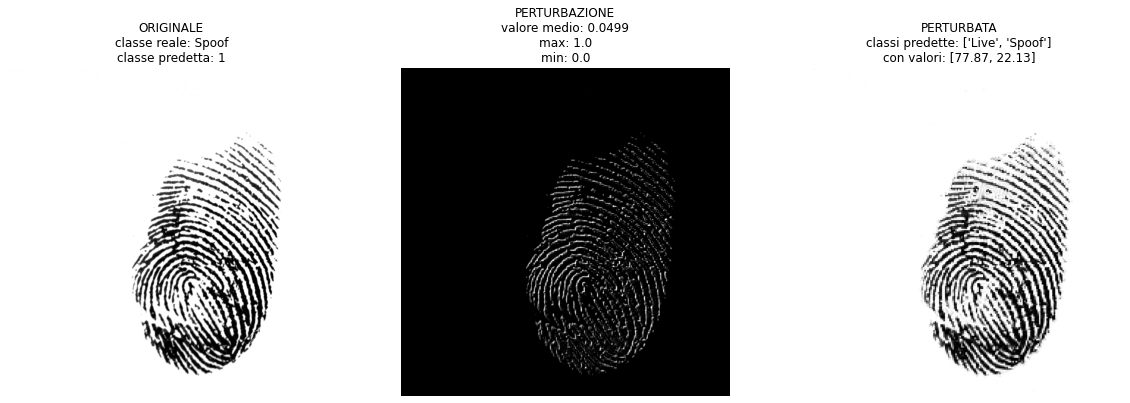

IMMAGINE  1


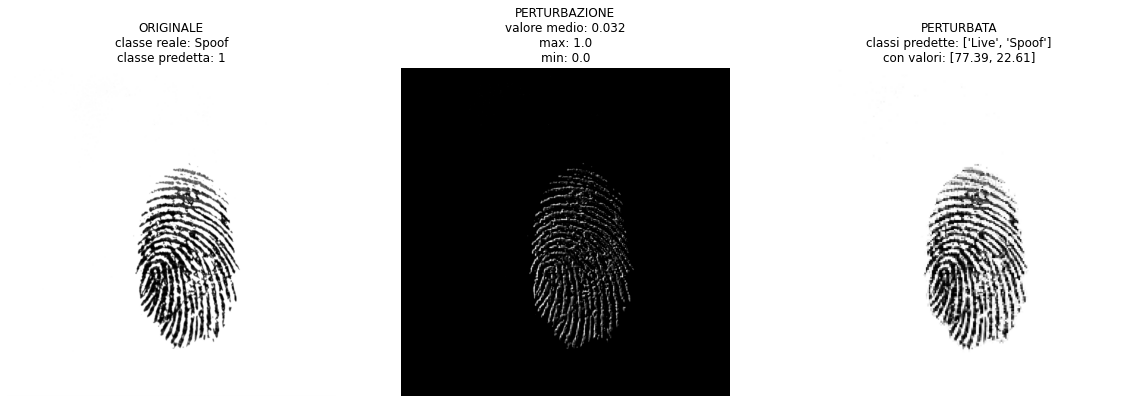

IMMAGINE  2


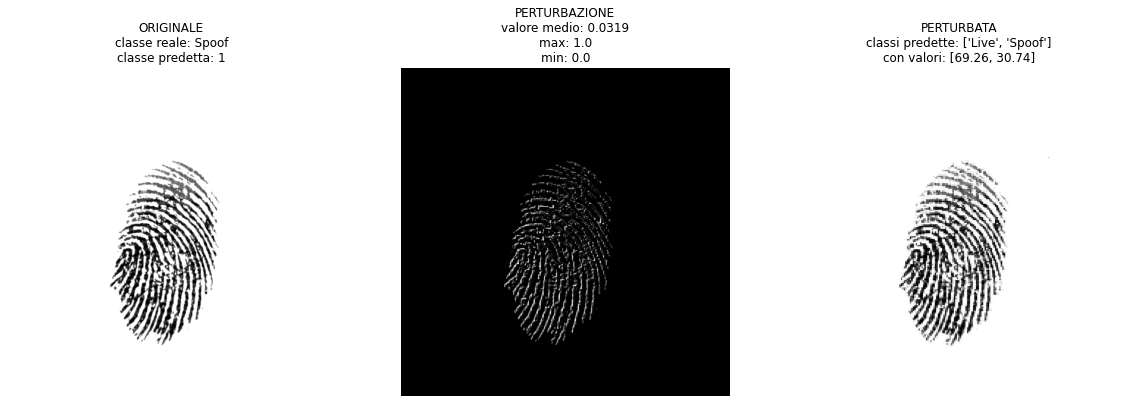

IMMAGINE  3


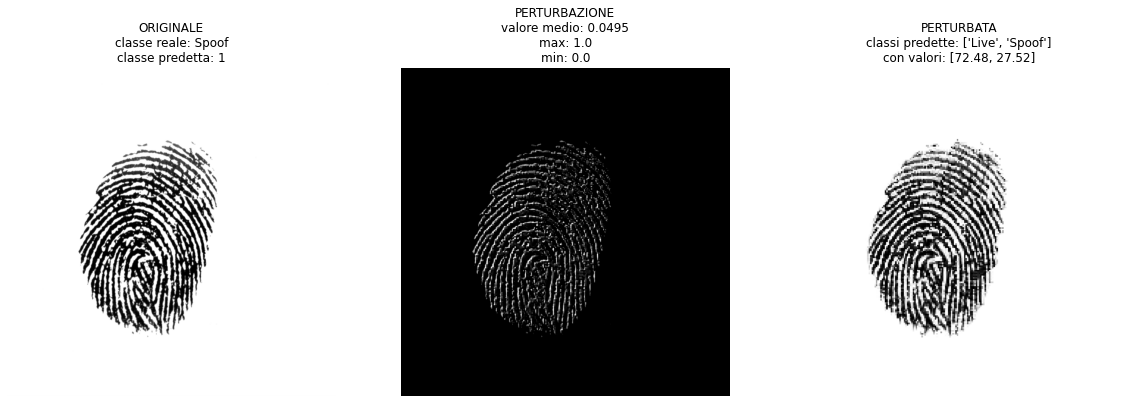

IMMAGINE  4


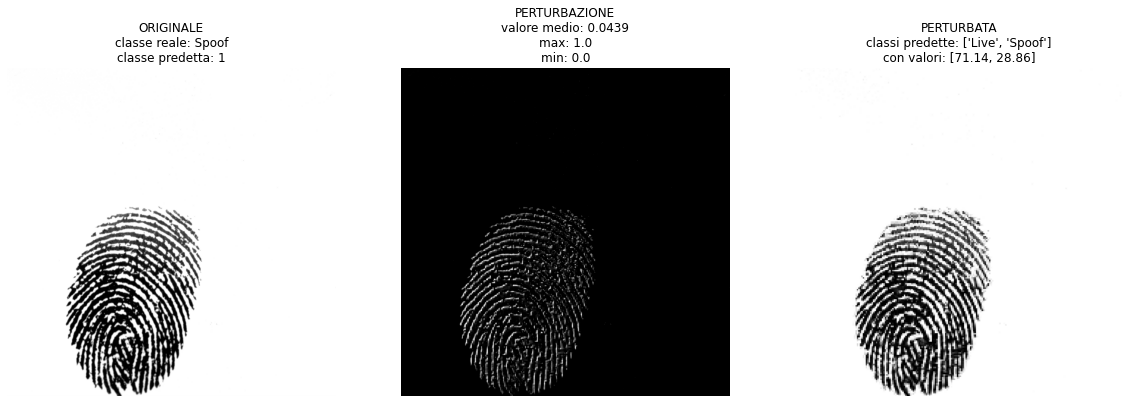

IMMAGINE  5


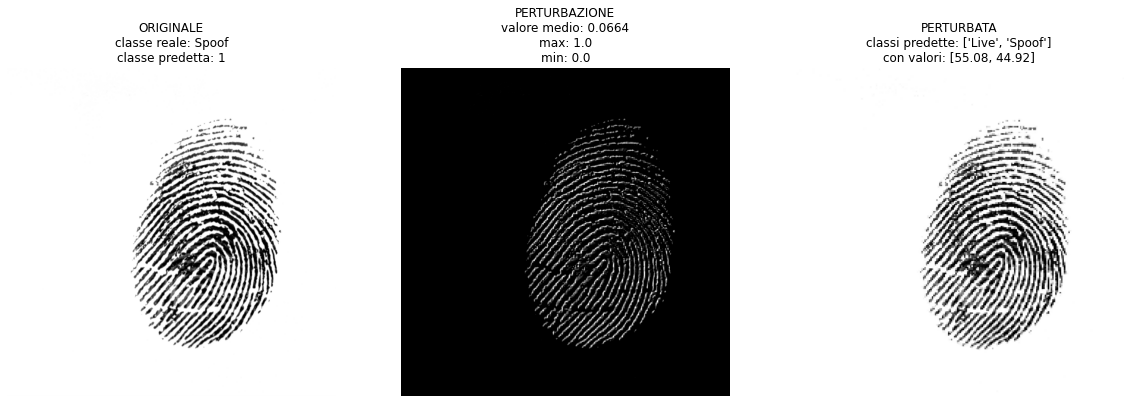

IMMAGINE  6


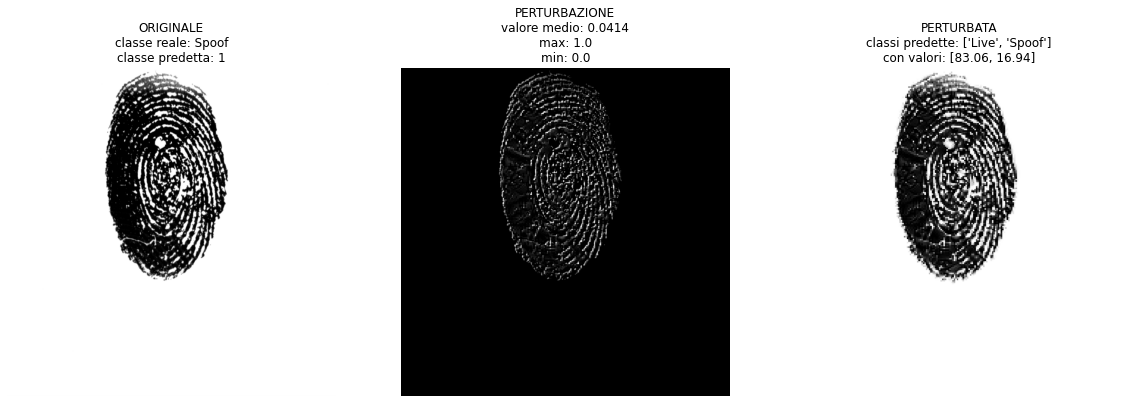

IMMAGINE  7


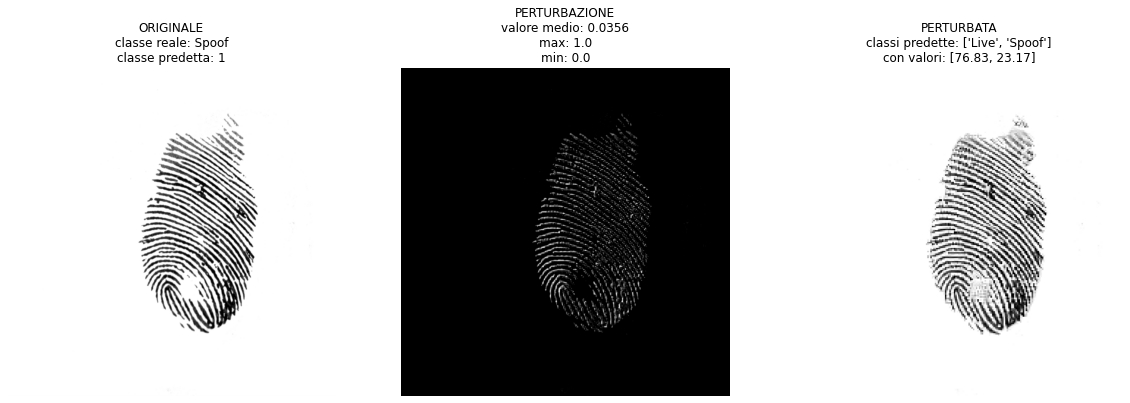

IMMAGINE  8


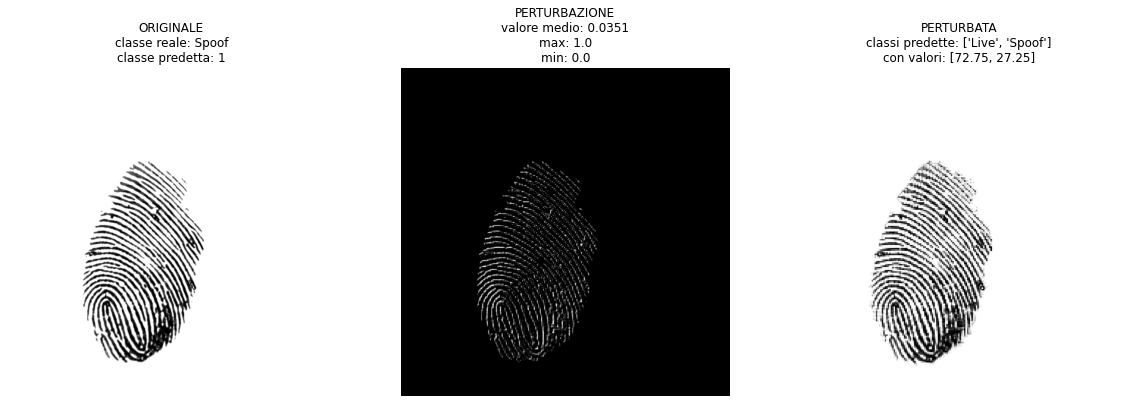

IMMAGINE  9


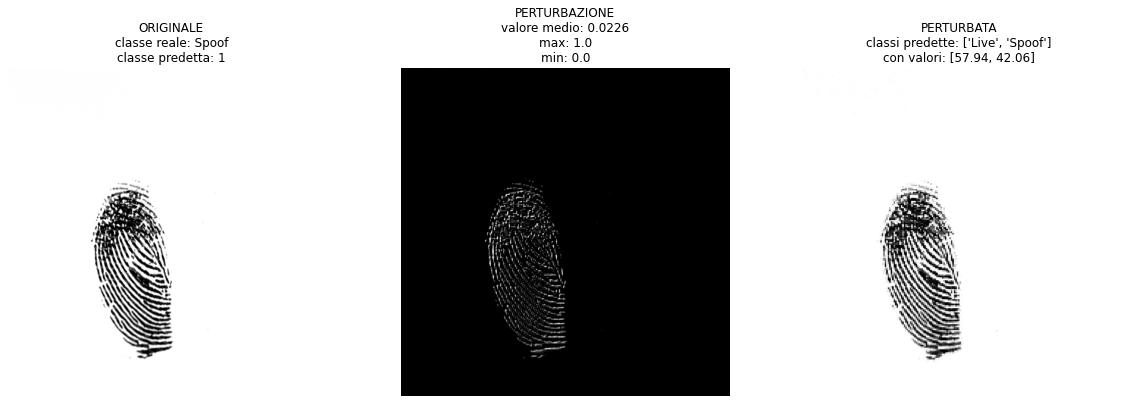

In [262]:
#da usare solo con dataset ridotto
preds_orig=[]
for input,_ in testgen:
  preds_orig_i,_=test_average_preds(classifier,input)
  preds_orig.append(preds_orig_i)
preds_orig=np.array(preds_orig)
preds_orig=preds_orig[list_print]
print_subplot(x_print,y_print,preds_orig,x_print_adv,y_print_adv,normalize=False)

#prova salvataggio e lettura immagine

0 255


(0, array([ 2.8370285, -1.5031711], dtype=float32))

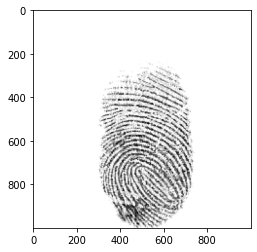

In [ ]:
from PIL import Image
arr_init=np.array(x_print_adv[i]).transpose(1,2,0)
arr_init=(arr_init-np.min(arr_init))/(np.max(arr_init)-np.min(arr_init))
print(np.min(arr_init),np.max(arr_init))
plt.imsave('prova.bmp',arr_init)
plt.imshow(arr_init)
test_average_values(classifier,torch.Tensor(x_print_adv[i]).unsqueeze_(0))

0 255


(0, array([ 2.8370285, -1.5031711], dtype=float32))

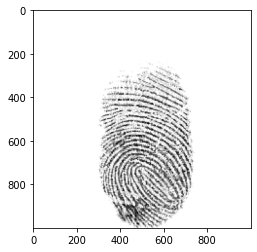

In [ ]:
prova_arr=plt.imread('prova.bmp')
prova_arr=(prova_arr-np.min(prova_arr))/(np.max(prova_arr)-np.min(prova_arr))
print(np.min(prova_arr),np.max(prova_arr))
plt.imshow(prova_arr)
test_average_values(classifier,torch.Tensor(prova_arr.transpose(2,0,1)).unsqueeze_(0))